# TD4

In [4]:
# imports : run pip install -r requirements.txt before running the code - TODO: explain it in the README.md
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

(74111, 30)
Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'price'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities              

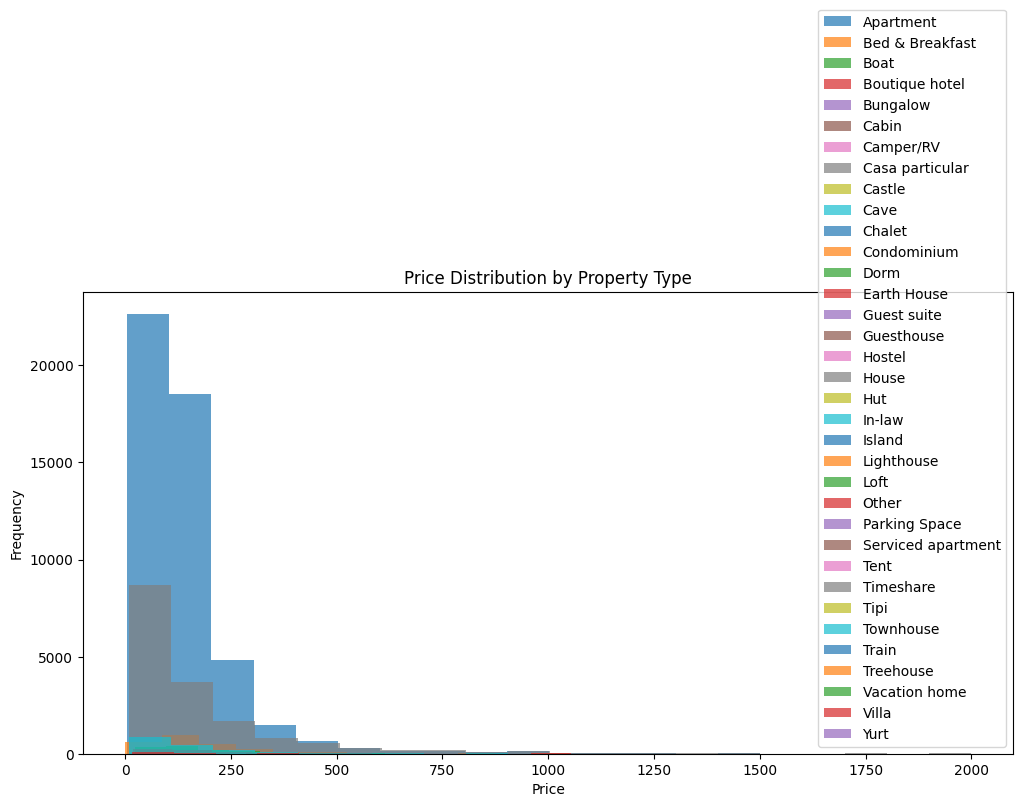

In [5]:
# the data is from : https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction

data = pd.read_csv("train.csv")
data['price'] = np.exp(data['log_price'])
print(data.shape)
print(data.columns)
data.head()
data.info()

data.describe()


price_and_type = data.groupby('property_type')['price']

# Plotting a histogram for each property type
plt.figure(figsize=(12, 6))
for property_type, prices in price_and_type:
    plt.hist(prices, bins=20, alpha=0.7, label=property_type)

plt.title('Price Distribution by Property Type')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Question 3.
Let’s begin with some visualisations.
• Based on your intuition what are the most important variables for predicting your target variable?
• Create visualisations that take into account the type of variable (categorical, numerical) that show
the correlation of the features you selected.
• Don’t forget to clean your dataset as needed in order to deal with missing values and outliers

Missing Values:
id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
price                         0
dtype: int64


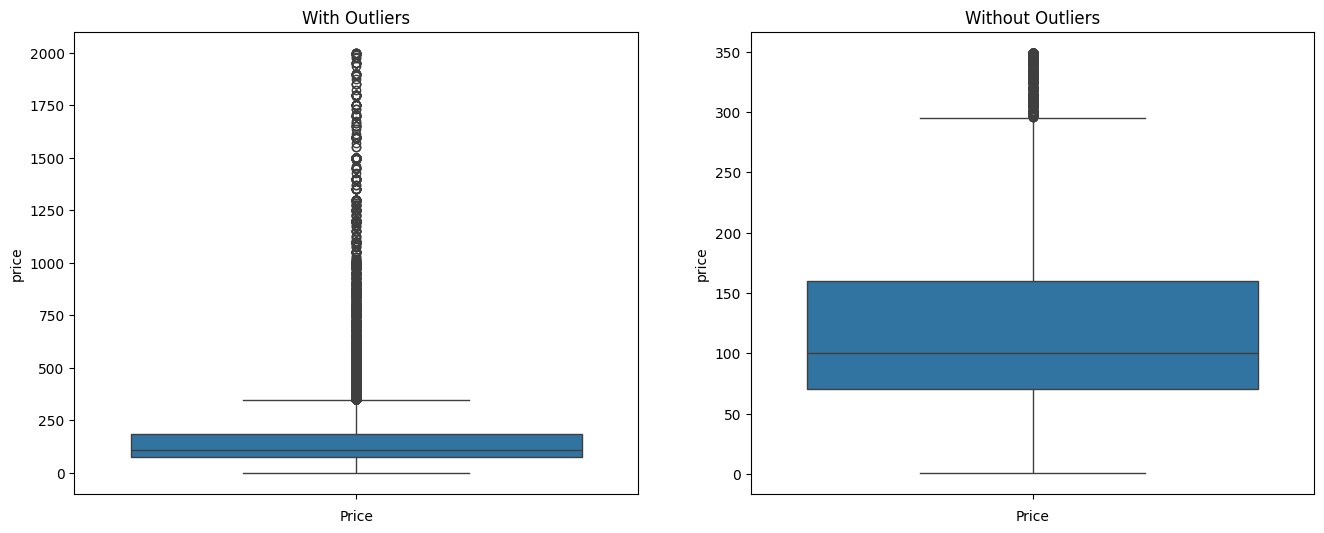

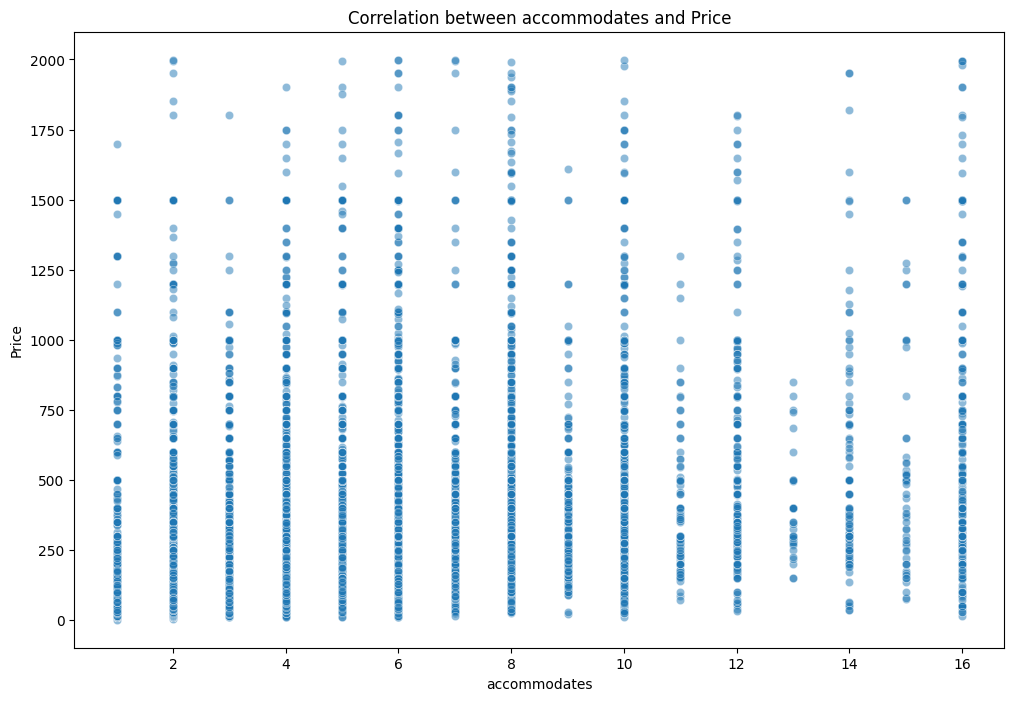

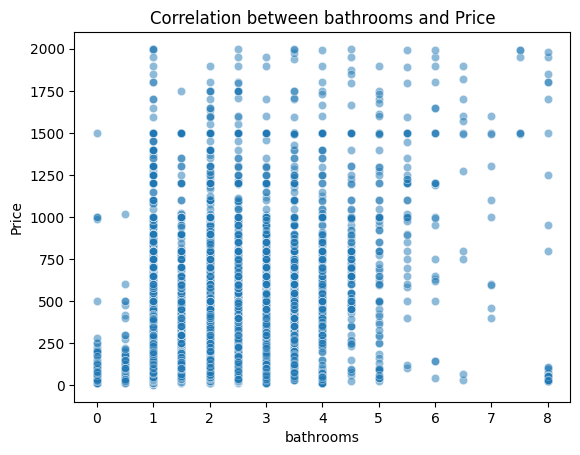

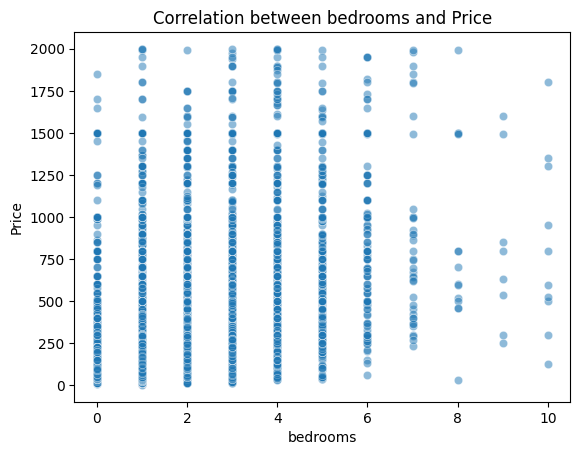

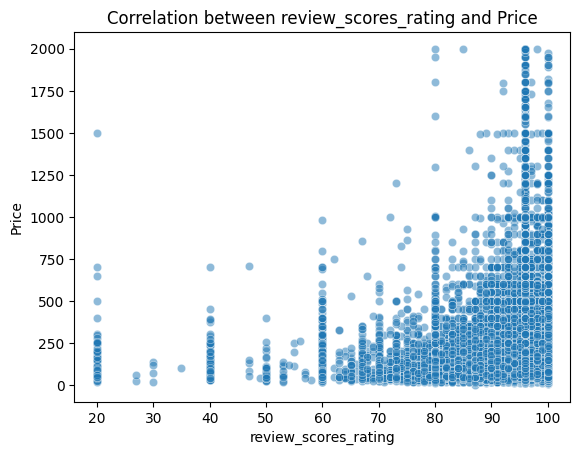

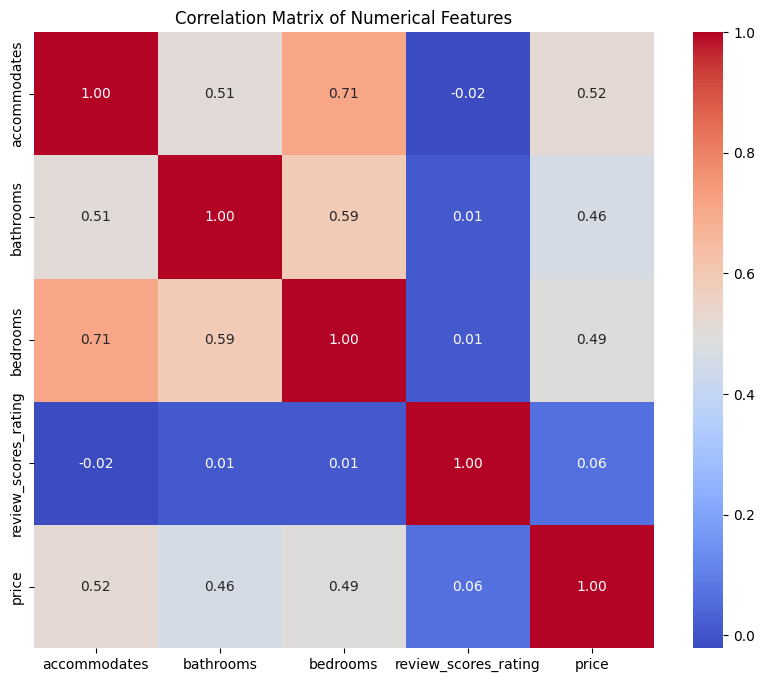

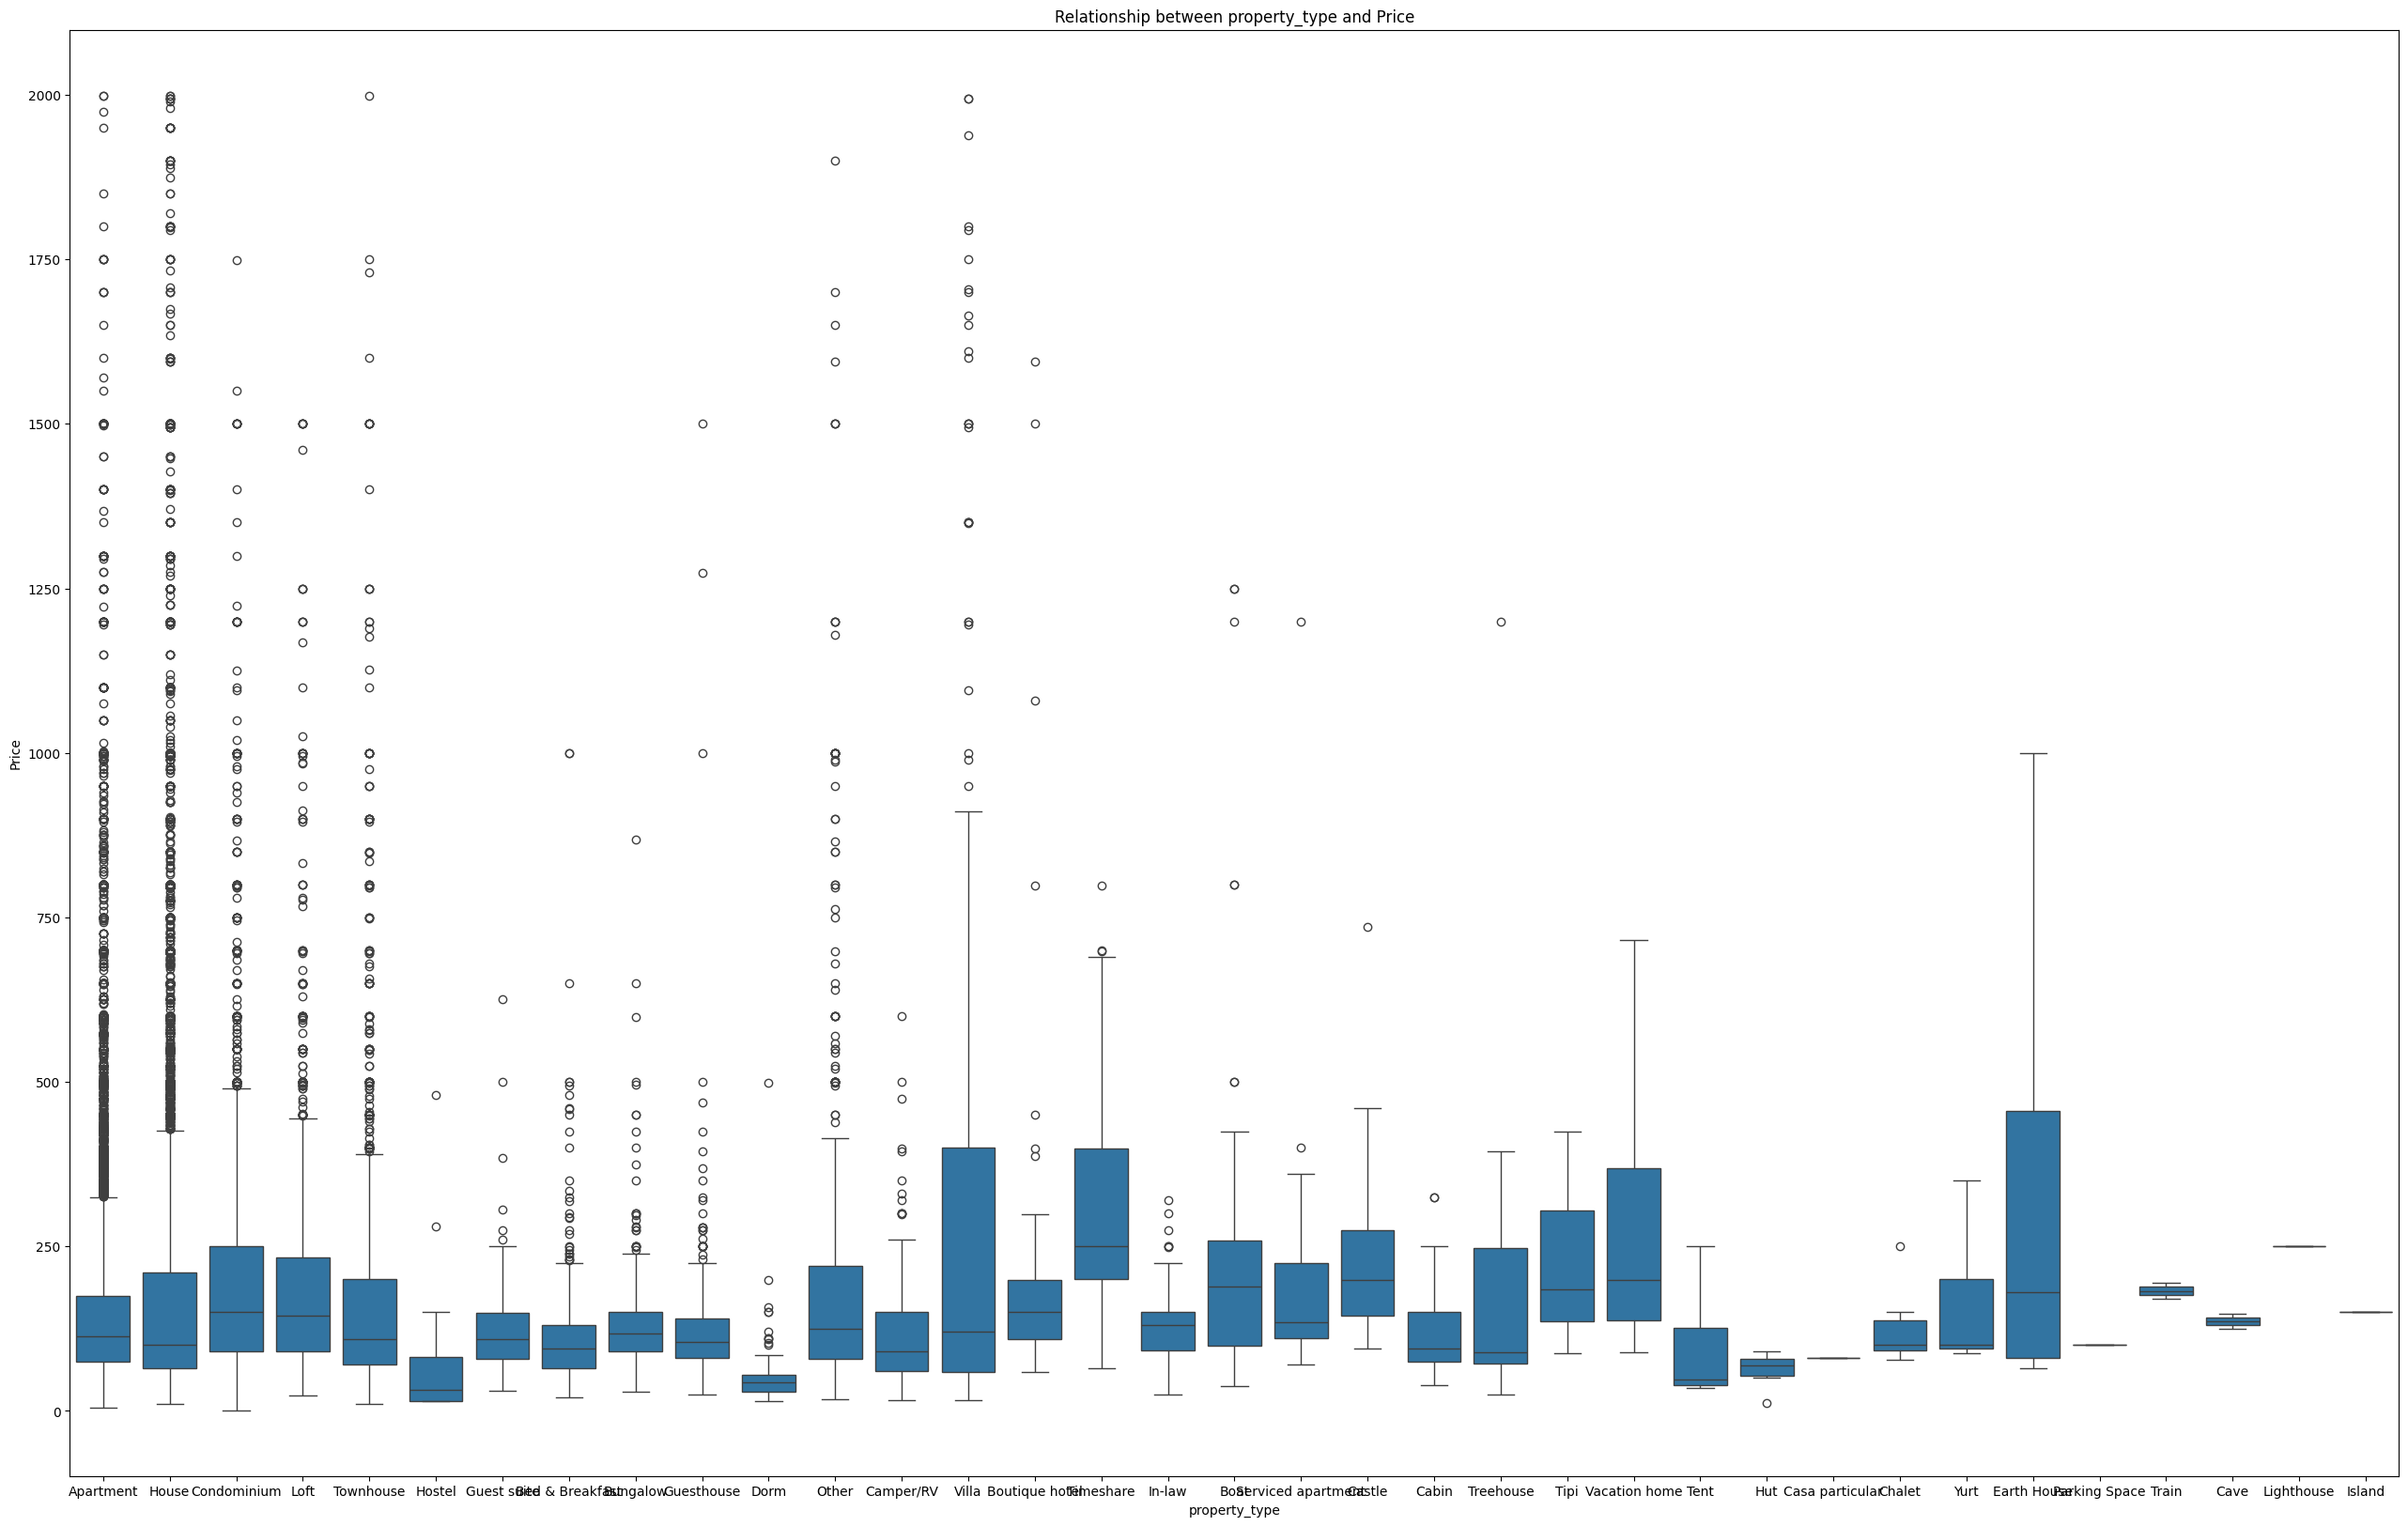

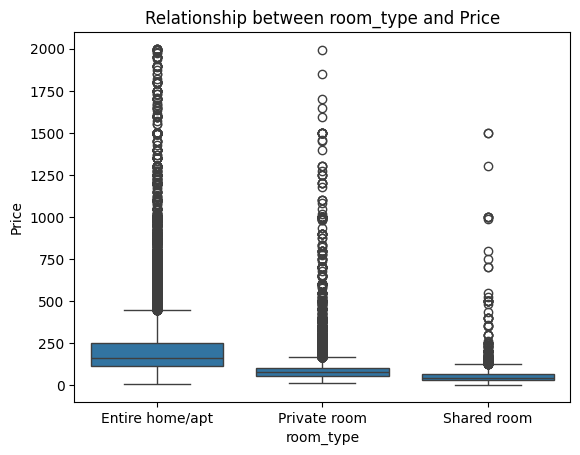

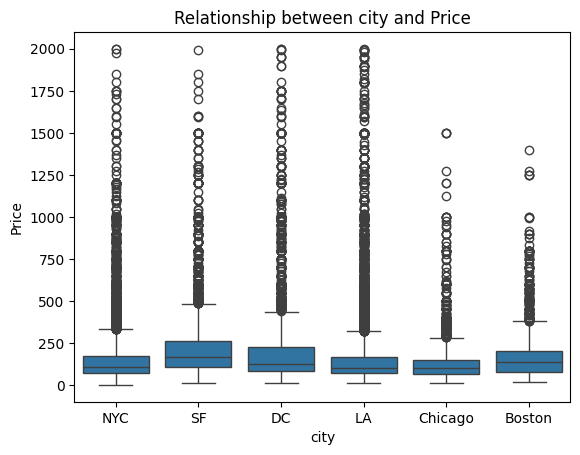

In [6]:

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

# Handle missing values
for column in data.columns:
    if data[column].dtype in ['float64', 'int64']:
        data[column] = data[column].fillna(data[column].median())
    elif data[column].dtype == 'object':
        data[column] = data[column].fillna(data[column].mode().iloc[0])

# Handle outliers
# For simplicity, let's focus on outliers in the target variable 'price'
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
data_filtered = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

# Plot boxplot of 'price' before and after removing outliers
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data['price'])
plt.title('With Outliers')
plt.xlabel('Price')

plt.subplot(1, 2, 2)
sns.boxplot(data_filtered['price'])
plt.title('Without Outliers')
plt.xlabel('Price')

plt.show()

# Plot correlation of numerical features with target variable
numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'review_scores_rating']
plt.figure(figsize=(12, 8))
for feature in numerical_features:
    sns.scatterplot(x=data[feature], y=data['price'], alpha=0.5)
    plt.title(f'Correlation between {feature} and Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'review_scores_rating', 'price']
numerical_data = data[numerical_features]
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

    
# Plot relationship between categorical features and target variable
categorical_features = ['property_type', 'room_type', 'city']
plt.figure(figsize=(32, 20))
for feature in categorical_features:
    sns.boxplot(x=data[feature], y=data['price'])
    plt.title(f'Relationship between {feature} and Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()


Question 4.
Let’s do a linear regression.
• Do the variable transformations that are needed (on hot encoding, log etc...) • Fit the linear regression
• Interpret the coeﬀicients of your regression
• Does any coeﬀicient contradict your intuition?

In [7]:

# # Split data into features and target variable
# features = ['accommodates', 'bathrooms', 'bedrooms', 'review_scores_rating', 'property_type', 'room_type', 'city']
# X = data[features]
# y = data['log_price']

# # Creating a transformer for both numerical and categorical
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', 'passthrough', numerical_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Preprocessing the data
# X_processed = preprocessor.fit_transform(X)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# # Train a linear regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = model.score(X_test, y_test)

# # Print evaluation metrics
# print(f'MSE: {mse}, RMSE: {rmse}, R^2: {r2}')

# # Get names of the one-hot encoded columns
# ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)

# # Combine with numerical features to get the complete list
# feature_names = numerical_features + list(ohe_feature_names)

# # Create a DataFrame for coefficients
# coefficients = pd.DataFrame({
#     'Feature': feature_names,
#     'Coefficient': model.coef_
# }).sort_values(by='Coefficient', key=abs, ascending=False)  # Sort by absolute value

# # Calculate the sum of absolute values of coefficients for each category
# coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
# coefficients['Feature Category'] = coefficients['Feature'].apply(lambda x: x.split('_')[0])

# # Aggregate these absolute coefficients by category
# category_importance = coefficients.groupby('Feature Category')['Absolute Coefficient'].sum().reset_index()

# # Sort categories by their summed absolute coefficient
# category_importance_sorted = category_importance.sort_values(by='Absolute Coefficient', ascending=False)

# # Plot
# plt.figure(figsize=(10, 8))
# sns.barplot(data=category_importance_sorted, x='Absolute Coefficient', y='Feature Category')
# plt.title('Importance of Feature Categories in Linear Regression')
# plt.xlabel('Sum of Absolute Coefficients')
# plt.ylabel('Feature Category')
# plt.tight_layout()
# plt.show()

Question 5.
Let’s build a more complex model
• Build the ”best” model you can using traditional data science (no deep learning) • Don’t hesitate to fine tune it, try different combination of variables etc
• What is the best metric you can reach? Can you consider it ”good”
• Given your results what use case can be done with this model?

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Define features and target variable
features = ['accommodates', 'bathrooms', 'bedrooms', 'review_scores_rating', 'property_type', 'room_type', 'city']
X = data[features]
y = data['log_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical features
numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'review_scores_rating']
categorical_features = ['property_type', 'room_type', 'city']

# Create a preprocessing and modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Try different regressors
regressors = [RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42), LinearRegression(), DecisionTreeRegressor(random_state=42)]

best_score = float('inf')
best_regressor = None

for regressor in regressors:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', regressor)])
    # Perform grid search or randomized search for hyperparameter tuning here if needed

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Regressor: {regressor.__class__.__name__}, RMSE: {rmse}')
    
    if rmse < best_score:
        best_score = rmse
        best_regressor = regressor

print(f'Best Regressor: {best_regressor.__class__.__name__}, Best RMSE: {best_score}')

Regressor: RandomForestRegressor, RMSE: 0.4736726281661533
Regressor: GradientBoostingRegressor, RMSE: 0.45779126930384967
Regressor: LinearRegression, RMSE: 0.4783208144563809
Regressor: DecisionTreeRegressor, RMSE: 0.5037051888716466
Best Regressor: GradientBoostingRegressor, Best RMSE: 0.45779126930384967


Question 6.
Using shapley values explain your model
• Start by giving some forceplot examples
• Use the feature importance and identify the most important variables
• Compare them to the variables identified in the linear regression
• Using the beeswarm plot explain the model behaviour for the most important variables
• Use dependance plots in order to understand the behaviour of the most important variables

In [10]:
import shap
# Convertir X_train et X_test transformés en format dense si nécessaire
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
if hasattr(X_train_transformed, "toarray"):  # Vérifie si le résultat est une matrice creuse
    X_train_transformed = X_train_transformed.toarray()
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# Initialiser SHAP
shap.initjs()

explainer = shap.TreeExplainer(best_regressor)
shap_values = explainer.shap_values(X_test_transformed)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_transformed[0,:], feature_names=features)

/Users/thomas/Documents/TD4_Explainability_AI/ia/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

# Transformation des jeux de données
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convertir en un tableau dense si les données transformées sont des matrices creuses
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# Initialisation des visualisations SHAP
shap.initjs()

# Création de l'Explainer SHAP avec les données transformées
explainer = shap.Explainer(best_regressor.predict, X_train_transformed)

# Calcul des valeurs SHAP pour l'ensemble des données de test transformées
shap_values = explainer(X_test_transformed)

PermutationExplainer explainer: 14824it [03:33, 66.39it/s]                           


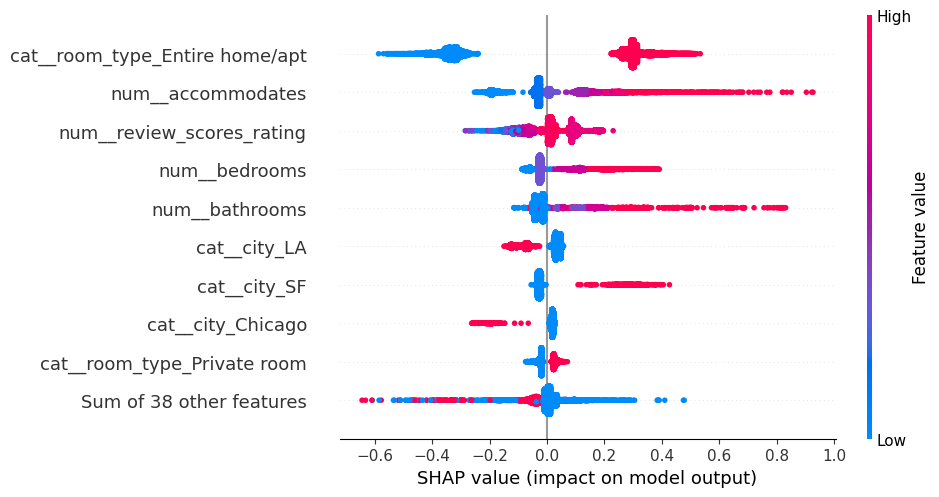

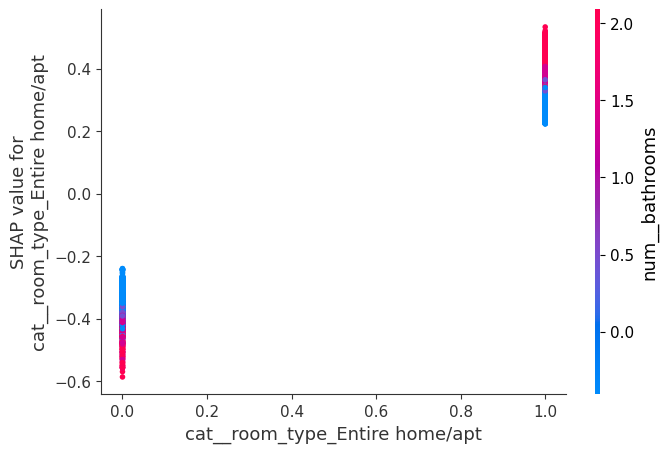

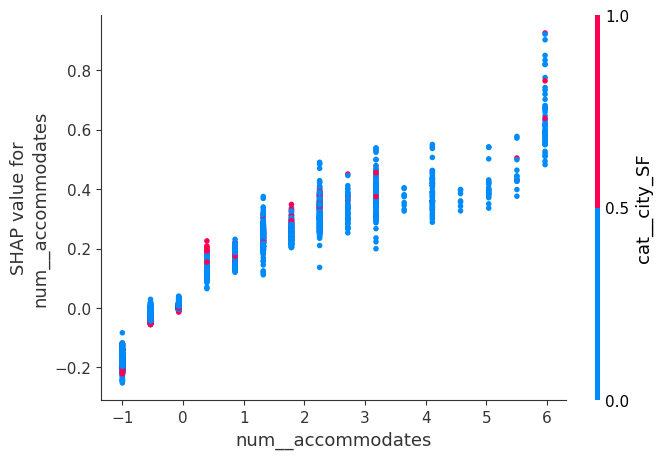

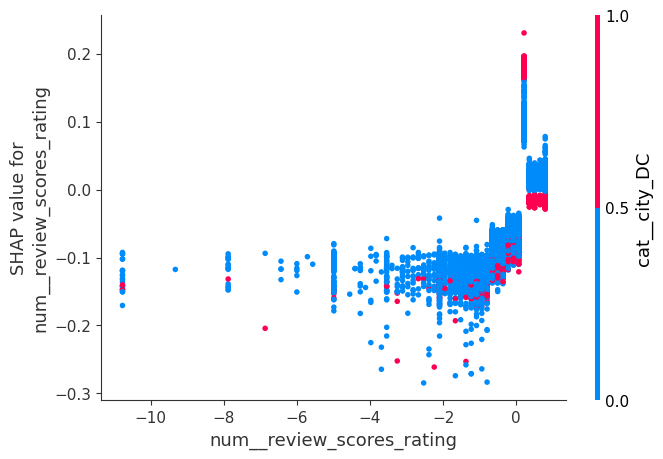

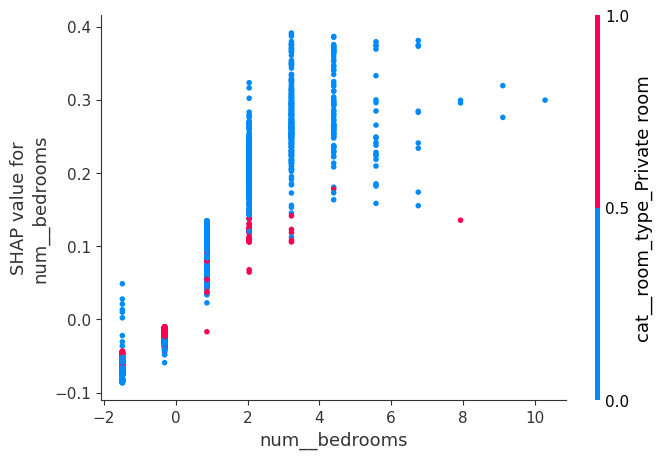

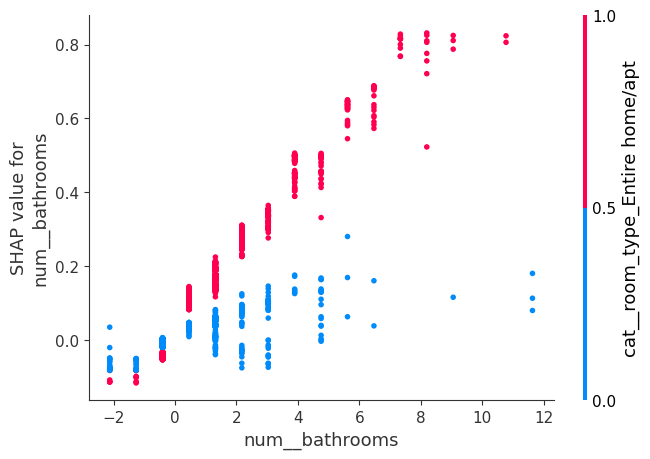

In [12]:

# Récupération des vrais noms des caractéristiques après la transformation
feature_names_transformed = list(preprocessor.get_feature_names_out())

# Associer les noms des caractéristiques à l'objet shap_values
shap_values.feature_names = feature_names_transformed

# Beeswarm plot avec les vrais noms des caractéristiques
shap.plots.beeswarm(shap_values, max_display=10)

# Calcul de l'importance moyenne des caractéristiques basée sur les valeurs SHAP absolues
shap_sum = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame([feature_names_transformed, shap_sum.tolist()]).T
importance_df.columns = ['feature_name', 'shap_importance']
importance_df.sort_values('shap_importance', ascending=False, inplace=True)

# Sélection des noms des caractéristiques les plus importantes
num_features = 5
top_features = importance_df.head(num_features)['feature_name'].tolist()

# Génération des dependence plots pour les caractéristiques les plus importantes
for feature_name in top_features:
    feature_index = feature_names_transformed.index(feature_name)
    shap.dependence_plot(feature_index, shap_values.values, X_test_transformed, feature_names=feature_names_transformed)

Question 7.
We will now do a clusteirng of shapley values.
• Let’s reduce the dimension of our data for visualisation purposes. Do a PCA with the shapley values and visualise the 2 principal axis.
• Given the visualisation choose a clustering algorithm (K-Means, DBSCAN, gausian mixture...) and try to cluster the shapley values of the property.
• Visualise your results
• What characteristics can you give to each cluster?
• What conclusion can you reach?

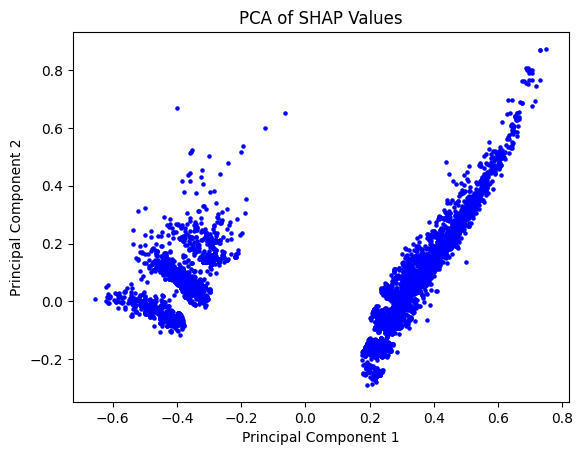

In [13]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  # ou un autre algorithme de clustering de votre choix
import matplotlib.pyplot as plt

# Étape 1: Réduction de la dimensionnalité avec PCA
pca = PCA(n_components=2)  # Utiliser 2 composantes pour la visualisation en 2D
shap_values_reduced = pca.fit_transform(shap_values.values)

# Étape 2: Visualisation des deux premiers axes principaux
plt.scatter(shap_values_reduced[:, 0], shap_values_reduced[:, 1], s=5, color='blue')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of SHAP Values')
plt.show()

In [17]:
# Étape 3: Clustering des valeurs de Shapley réduites
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)

In [18]:
clusters = kmeans.fit_predict(shap_values_reduced)

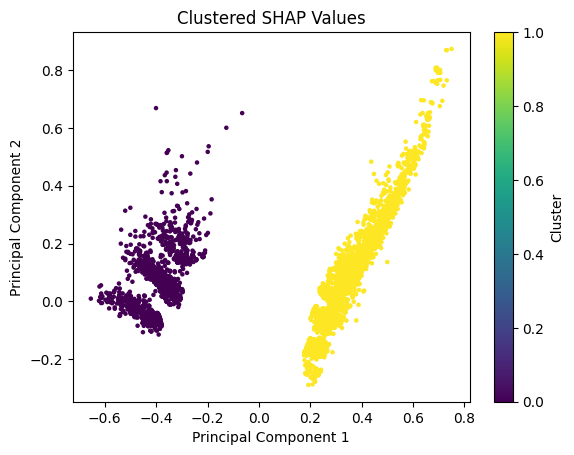

In [19]:
# Étape 4: Visualisation des résultats du clustering
plt.scatter(shap_values_reduced[:, 0], shap_values_reduced[:, 1], c=clusters, cmap='viridis', s=5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered SHAP Values')
plt.colorbar(label='Cluster')
plt.show()